# DATA EXPLORATION

In [19]:
import os
import json
import glob

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

# Optional: nicer DataFrame display
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 50)


In [20]:
def parse_scopus_record(rec):
    """
    Take a raw JSON record (loaded from one Scopus file)
    and extract the most important fields into a flat dictionary.
    """

    root = rec.get("abstracts-retrieval-response", {})
    item = root.get("item", {})
    core = root.get("coredata", {})
    bib = item.get("bibrecord", {}).get("head", {})
    
    # ---- Title ----
    title = core.get("dc:title")
    
    # ---- Abstract ----
    # Prefer the 'bibrecord' abstract, fall back to core description if missing
    abstract = bib.get("abstracts")
    if abstract is None:
        abstract = core.get("dc:description")
    
    # ---- Year ----
    year = None
    if "prism:coverDate" in core:
        # coverDate is a string like "2022-02-01"
        year = core.get("prism:coverDate", "")[:4]
    
    # ---- DOI ----
    doi = core.get("prism:doi")
    
    # ---- Cited-by count ----
    citedby = core.get("citedby-count")
    try:
        citedby = int(citedby)
    except:
        citedby = None
    
    # ---- Authors ----
    authors = []
    groups = bib.get("author-group", [])
    for g in groups:
        for a in g.get("author", []):
            name = a.get("preferred-name", {})
            authors.append(name.get("ce:indexed-name"))
    
    # ---- Affiliations ----
    affiliations = []
    for g in groups:
        aff = g.get("affiliation", {})
        txt = aff.get("ce:source-text")
        if txt:
            affiliations.append(txt)
            
    # ---- Keywords (idxterms) ----
    keywords = []
    idx = root.get("idxterms", {}).get("mainterm", [])
    for kw in idx:
        keywords.append(kw.get("$"))
    
    # ---- Subject areas ----
    subjects = []
    subj_list = root.get("subject-areas", {}).get("subject-area", [])
    for s in subj_list:
        subjects.append(s.get("$"))
    
    return {
        "title": title,
        "abstract": abstract,
        "year": year,
        "doi": doi,
        "citedby": citedby,
        "authors": authors,
        "affiliations": affiliations,
        "keywords": keywords,
        "subjects": subjects,
    }


In [21]:
DATA_DIR = "ScopusData2018-2023"  # adapt this path if needed

# List every path under DATA_DIR (files + directories)
all_paths = glob.glob(f"{DATA_DIR}/**/*", recursive=True)

# Keep only files (ignore directories)
all_files = [p for p in all_paths if os.path.isfile(p)]

print("Total number of files found:", len(all_files))

records = []

for path in tqdm(all_files):
    try:
        with open(path, "r", encoding="utf-8") as f:
            raw = json.load(f)
            clean = parse_scopus_record(raw)
            records.append(clean)
    except Exception as e:
        # If some files are malformed or not JSON, we skip them silently
        # You can uncomment the print below for debugging
        # print(f"Error on {path}: {e}")
        pass

df = pd.DataFrame(records)
df.head()


Total number of files found: 20216


100%|██████████| 20216/20216 [01:03<00:00, 320.53it/s]


,title,abstract,year,doi,citedby,authors,affiliations,keywords,subjects
0,Direct immunofluorescence staining patterns compared between oral and cutaneous lichen planus,"© 2021 British Association of Dermatologists.This retrospective study performed to investigate direct immunofluorescence (DIF) findings in oral and cutaneous lichen planus (LP), and to identify an...",2022,10.1111/ced.14879,0,"[Rujitharanawong C., Tuchinda P., Chularojanamontri L., Pochanapan O., Nuttawong S., Kulthanan K., Thongprasom K.]","[Department of Dermatology, Faculty of Medicine Siriraj Hospital, Mahidol University, Bangkok, Thailand, Department of Oral Medicine, Faculty of Dentistry, Chulalongkorn University, Bangkok, Thail...","[Adult, Female, Fibrin, Fluorescent Antibody Technique, Direct, Humans, Immunoglobulin M, Lichen Planus, Lichen Planus, Oral, Male, Middle Aged, Retrospective Studies, Skin]",[Dermatology]
1,Multilocus Sequence Typing and Virulence Potential of Vibrio parahaemolyticus Strains Isolated from Aquatic Bird Feces,"Copyright © 2022 Muangnapoh et al.Vibrio parahaemolyticus is a Gram-negative, foodborne pathogenic bacterium that causes human gastroenteritis. This organism is ubiquitously present in the marine ...",2022,10.1128/spectrum.00886-22,1,"[Muangnapoh C., Muangnapoh C., Supha N., Toyting J., Chitrak A., Ekchariyawat P., Suthienkul O., Tamboon E., Kitkumthorn N., Iida T.]","[Department of Microbiology, Faculty of Science, Chulalongkorn University, Bangkok, Thailand, Department of Microbiology, Faculty of Public Health, Mahidol University, Bangkok, Thailand, Departmen...","[Animals, Birds, Feces, Humans, Multilocus Sequence Typing, Thailand, Vibrio Infections, Vibrio parahaemolyticus, Virulence, Virulence Factors]","[Physiology, Ecology, Immunology and Microbiology (all), Genetics, Microbiology (medical), Cell Biology, Infectious Diseases]"
2,Atrial fibrillation ablation in hemodialysis patients: a new realm on the overlooked,None,2022,10.21037/apm-22-1041,0,"[Prasitlumkum N., Chokesuwattanaskul R., Cheungpasitporn W.]","[Division of Cardiology, University of California Riverside, Riverside, CA, USA;, Division of Cardiovascular Medicine, Department of Medicine, Faculty of Medicine, Chulalongkorn University and Kin...","[Atrial Fibrillation, Catheter Ablation, Humans, Renal Dialysis, Treatment Outcome]","[Advanced and Specialized Nursing, Anesthesiology and Pain Medicine]"
3,Third Asia-Pacific consensus recommendations on colorectal cancer screening and postpolypectomy surveillance,© The Asia-Pacific region has the largest number of cases of colorectal cancer (CRC) and one of the highest levels of mortality due to this condition in the world. Since the publishing of two cons...,2022,10.1136/gutjnl-2022-327377,11,"[Sung J.J.Y., Wong S., Chiu H.M., Chiu H.M., Lieberman D., Kuipers E.J., Rutter M.D., MacRae F., Yeoh K.G., Ang T.L., Chong V.H., John S., Li J., Wu K., Ng S.S.M., Makharia G.K., Abdullah M., Abdu...","[Lee Kong Chian School of Medicine, Singapore, Department of Internal Medicine, National Taiwan University Hospital, Taipei, Taiwan, Department of Internal Medicine, College of Medicine, National ...","[Adenoma, Asia, Colonic Polyps, Colonoscopy, Colorectal Neoplasms, Consensus, Early Detection of Cancer, Humans]",[Gastroenterology]
4,Responsiveness of the UW Concerns about Pain Scale and UW Pain-Related Self-Efficacy Scale in Individuals with Chronic Low Back Pain,"© 2022 Lippincott Williams and Wilkins. All rights reserved.Objectives: The aim was to examine the responsiveness, presence of floor or ceiling effects, and minimal clinically important difference...",2022,10.1097/AJP.0000000000001043,0,"[Akkarakittichoke N., Janwantanakul P., Kanlayanaphotporn R., Jensen M.P.]","[Inter-Department Program of Biomedical Sciences Faculty of Graduate school, Department of Physical Therapy Faculty of Allied Health Sciences Chulalongkorn University Bangkok Thailand, Department ...","[Chronic Pain, Disability Evaluation, Humans, Low

In [22]:
df.columns
# ['title', 'abstract', 'year', 'doi', 'citedby',
#  'authors', 'affiliations', 'keywords', 'subjects', 'abstract_length']


Index(['title', 'abstract', 'year', 'doi', 'citedby', 'authors',
       'affiliations', 'keywords', 'subjects'],
      dtype='object')

## 2. Basic numeric fields and helper columns

We add a few helper columns for EDA:
- `abstract_length`: length of the abstract (characters).
- `n_authors`: number of authors per paper.
- `n_keywords`: number of keywords per paper.
- `n_subjects`: number of subject areas per paper.


In [23]:
# Abstract length if not already computed
if "abstract_length" not in df.columns:
    df["abstract_length"] = df["abstract"].str.len()

# Number of authors / keywords / subjects
df["n_authors"] = df["authors"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df["n_keywords"] = df["keywords"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df["n_subjects"] = df["subjects"].apply(lambda x: len(x) if isinstance(x, list) else 0)

df[["year", "abstract_length", "n_authors", "n_keywords", "n_subjects"]].describe()


,abstract_length,n_authors,n_keywords,n_subjects
count,9983.000000,10237.000000,10237.000000,10237.000000
mean,1509.237103,30.378724,10.219107,2.645697
std,456.345038,225.414379,3.953935,1.626818
min,225.000000,2.000000,2.000000,1.000000
25%,1206.000000,5.000000,8.000000,1.000000
50%,1491.000000,7.000000,10.000000,2.000000
75%,1783.000000,11.000000,12.000000,4.000000
max,6754.000000,3087.000000,32.000000,12.000000


## 3. Publications per year

We start by checking how many documents we have per year.
This gives a global overview of the corpus and can show growth or decline in publication volume.


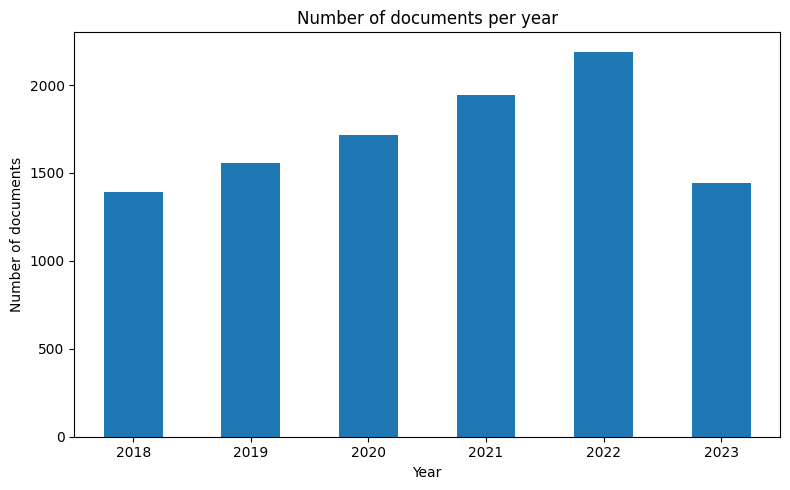

year
2018    1392
2019    1556
2020    1714
2021    1945
2022    2190
2023    1440
Name: count, dtype: int64

In [24]:
year_counts = df["year"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
year_counts.plot(kind="bar")
plt.title("Number of documents per year")
plt.xlabel("Year")
plt.ylabel("Number of documents")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

year_counts


## 4. Abstract length distribution

We inspect the distribution of abstract lengths (in characters).
This can reveal:
- extremely short or long abstracts,
- possible anomalies in the data (e.g., missing or boilerplate text).


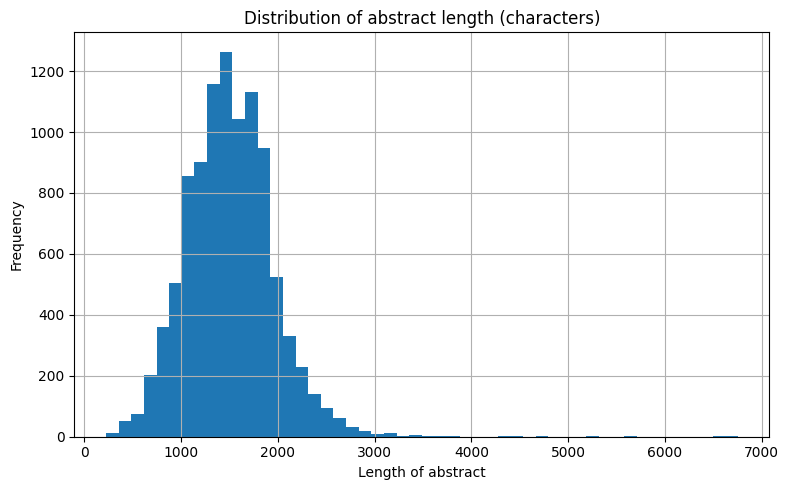

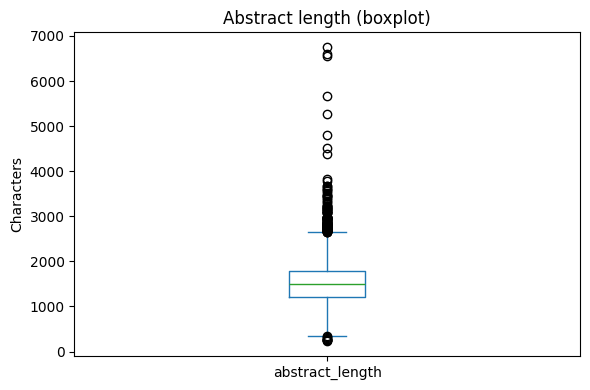

In [25]:
plt.figure(figsize=(8, 5))
df["abstract_length"].hist(bins=50)
plt.title("Distribution of abstract length (characters)")
plt.xlabel("Length of abstract")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optional: boxplot to see outliers
plt.figure(figsize=(6, 4))
df["abstract_length"].plot(kind="box")
plt.title("Abstract length (boxplot)")
plt.ylabel("Characters")
plt.tight_layout()
plt.show()


## 5. Citation statistics

We look at the distribution of citation counts (`citedby`).
Citations are usually heavy-tailed:
- most articles have few or zero citations,
- a small number of articles are highly cited.


Basic citation stats:
count    10237.000000
mean        12.405685
std         34.747577
min          0.000000
25%          1.000000
50%          5.000000
75%         13.000000
max       1356.000000
Name: citedby, dtype: float64


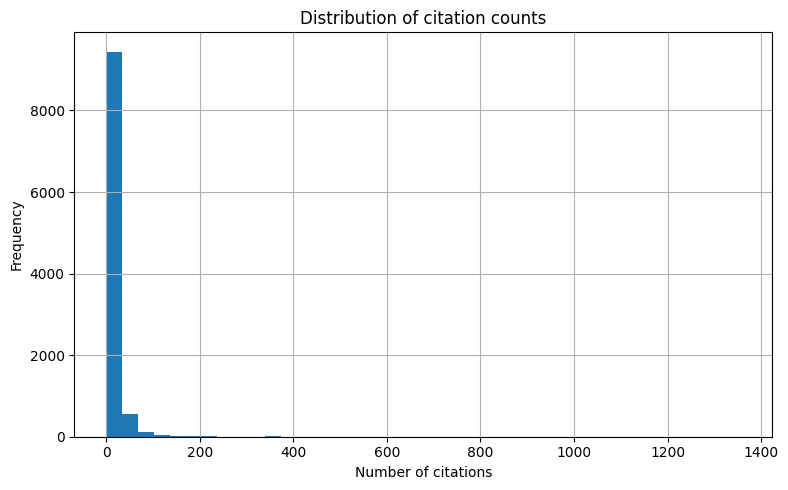

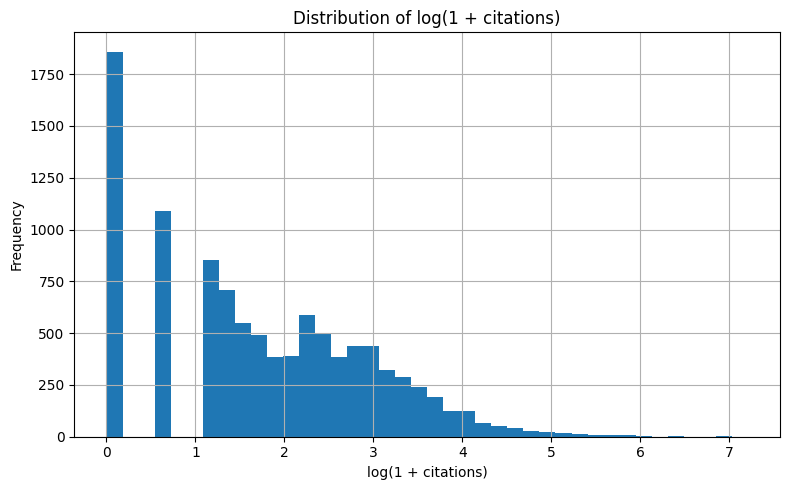

In [26]:
# Keep only non-null citation counts
df_cit = df[df["citedby"].notna()].copy()

print("Basic citation stats:")
print(df_cit["citedby"].describe())

plt.figure(figsize=(8, 5))
df_cit["citedby"].hist(bins=40)
plt.title("Distribution of citation counts")
plt.xlabel("Number of citations")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Log-scale histogram (to better see the tail)
plt.figure(figsize=(8, 5))
np.log1p(df_cit["citedby"]).hist(bins=40)
plt.title("Distribution of log(1 + citations)")
plt.xlabel("log(1 + citations)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 6. Number of authors per paper

We inspect how many co-authors each paper has.
This is relevant for understanding collaboration patterns
before building any co-authorship graph.


In [28]:
print("n_authors summary:")
print(df["n_authors"].describe())




n_authors summary:
count    10237.000000
mean        30.378724
std        225.414379
min          2.000000
25%          5.000000
50%          7.000000
75%         11.000000
max       3087.000000
Name: n_authors, dtype: float64


## 7. Top authors by number of documents

We "explode" the `authors` list so that each (paper, author) pair becomes one row,
then count how many times each author appears in the corpus.


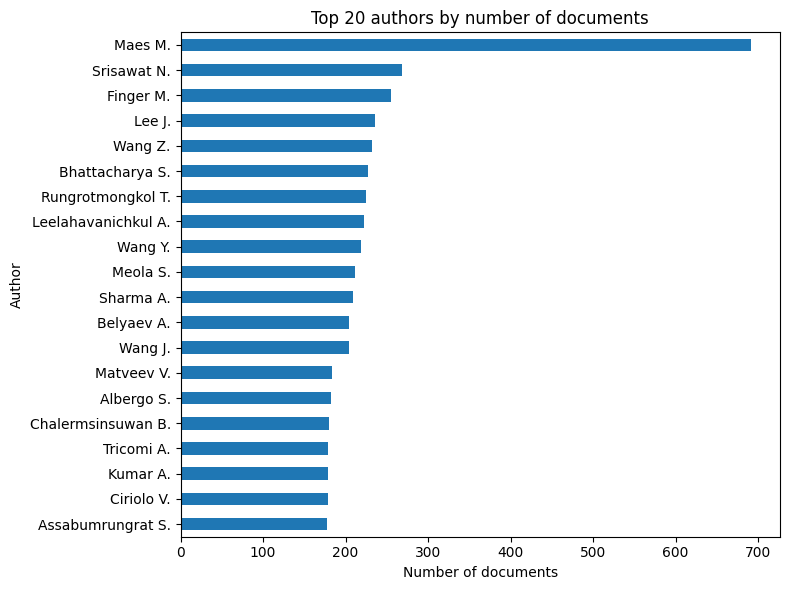

authors
Maes M.                692
Srisawat N.            268
Finger M.              255
Lee J.                 236
Wang Z.                232
Bhattacharya S.        227
Rungrotmongkol T.      225
Leelahavanichkul A.    222
Wang Y.                219
Meola S.               211
Sharma A.              209
Belyaev A.             204
Wang J.                204
Matveev V.             184
Albergo S.             182
Chalermsinsuwan B.     180
Kumar A.               179
Ciriolo V.             179
Tricomi A.             179
Assabumrungrat S.      178
Name: count, dtype: int64

In [29]:
# Explode authors list to one row per (paper, author)
df_authors = df.explode("authors")

# Drop rows where authors is NaN
df_authors = df_authors[df_authors["authors"].notna()]

top_authors = (
    df_authors["authors"]
    .value_counts()
    .head(20)
)

plt.figure(figsize=(8, 6))
top_authors.sort_values().plot(kind="barh")
plt.title("Top 20 authors by number of documents")
plt.xlabel("Number of documents")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

top_authors


## 8. Top affiliations / institutions

We do the same with the `affiliations` list: explode and count.
This gives an idea of which institutions contribute most to the corpus.


/var/folders/yz/w2h_1zhs2n98qhq0h_vcc7j80000gp/T/ipykernel_61868/893374014.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


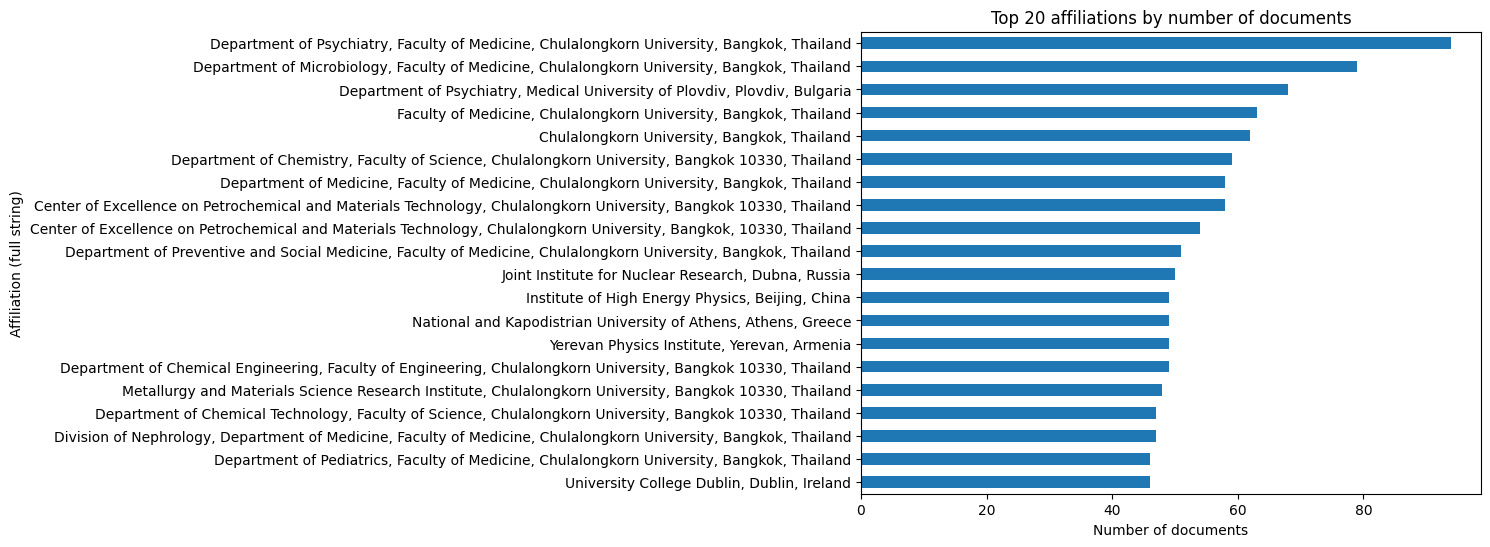

affiliations
Department of Psychiatry, Faculty of Medicine, Chulalongkorn University, Bangkok, Thailand                            94
Department of Microbiology, Faculty of Medicine, Chulalongkorn University, Bangkok, Thailand                          79
Department of Psychiatry, Medical University of Plovdiv, Plovdiv, Bulgaria                                            68
Faculty of Medicine, Chulalongkorn University, Bangkok, Thailand                                                      63
Chulalongkorn University, Bangkok, Thailand                                                                           62
Department of Chemistry, Faculty of Science, Chulalongkorn University, Bangkok 10330, Thailand                        59
Department of Medicine, Faculty of Medicine, Chulalongkorn University, Bangkok, Thailand                              58
Center of Excellence on Petrochemical and Materials Technology, Chulalongkorn University, Bangkok 10330, Thailand     58
Center of Excellenc

In [31]:
df_aff = df.explode("affiliations")
df_aff = df_aff[df_aff["affiliations"].notna()]

top_aff = (
    df_aff["affiliations"]
    .value_counts()
    .head(20)
)

plt.figure(figsize=(8, 6))
top_aff.sort_values().plot(kind="barh")
plt.title("Top 20 affiliations by number of documents")
plt.xlabel("Number of documents")
plt.ylabel("Affiliation (full string)")
plt.tight_layout()
plt.show()

top_aff

## 9. Subject areas distribution

Each document has one or more subject areas (e.g. "Dermatology").

We explode the `subjects` list and count the most represented subjects.


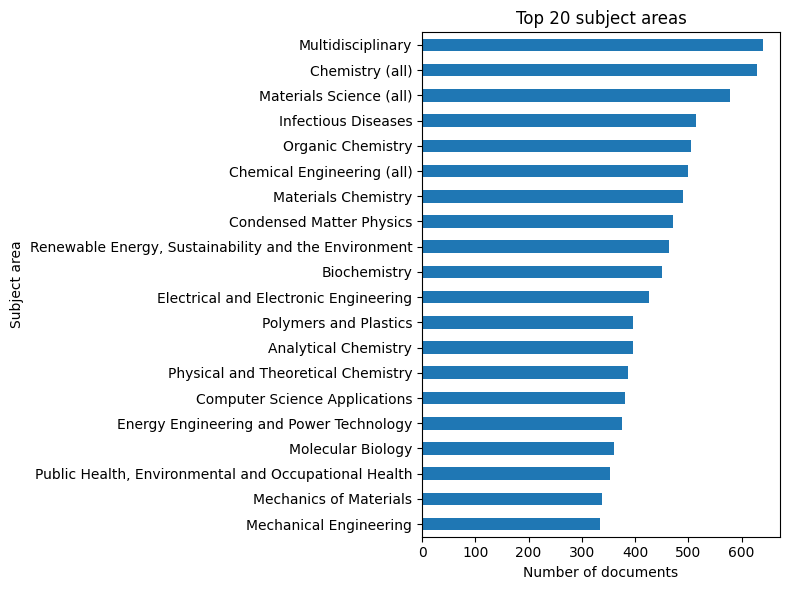

subjects
Multidisciplinary                                       640
Chemistry (all)                                         629
Materials Science (all)                                 579
Infectious Diseases                                     514
Organic Chemistry                                       504
Chemical Engineering (all)                              499
Materials Chemistry                                     490
Condensed Matter Physics                                471
Renewable Energy, Sustainability and the Environment    464
Biochemistry                                            450
Electrical and Electronic Engineering                   426
Polymers and Plastics                                   396
Analytical Chemistry                                    396
Physical and Theoretical Chemistry                      387
Computer Science Applications                           381
Energy Engineering and Power Technology                 375
Molecular Biology              

In [32]:
df_subj = df.explode("subjects")
df_subj = df_subj[df_subj["subjects"].notna()]

subject_counts = df_subj["subjects"].value_counts()

plt.figure(figsize=(8, 6))
subject_counts.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 subject areas")
plt.xlabel("Number of documents")
plt.ylabel("Subject area")
plt.tight_layout()
plt.show()

subject_counts.head(20)


## 10. Keyword frequency

We perform a similar analysis for `keywords` (idxterms).

This can give:
- a high-level view of the main concepts in the corpus,
- a starting point for later topic modeling or clustering.


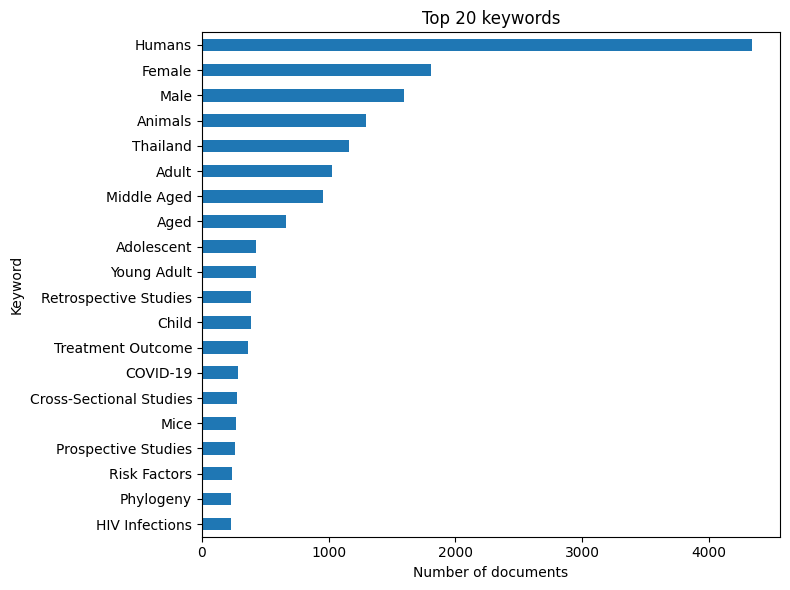

keywords
Humans                     4344
Female                     1809
Male                       1593
Animals                    1295
Thailand                   1160
Adult                      1030
Middle Aged                 954
Aged                        661
Adolescent                  426
Young Adult                 423
Retrospective Studies       386
Child                       385
Treatment Outcome           365
COVID-19                    282
Cross-Sectional Studies     279
Mice                        271
Prospective Studies         260
Risk Factors                241
Phylogeny                   232
HIV Infections              227
Name: count, dtype: int64

In [33]:
df_kw = df.explode("keywords")
df_kw = df_kw[df_kw["keywords"].notna()]

keyword_counts = df_kw["keywords"].value_counts()

plt.figure(figsize=(8, 6))
keyword_counts.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 keywords")
plt.xlabel("Number of documents")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

keyword_counts.head(20)


## 11. Citations vs. publication year

We now inspect average citation count by year.
Even in a limited time window (2018–2023), older papers tend to have more time to accumulate citations.


In [34]:
df_cit_year = df_cit.groupby("year")["citedby"].agg(["mean", "median", "count"])
df_cit_year


,mean,median,count
year,,,
2018,22.270115,12.0,1392
2019,18.885604,10.0,1556
2020,18.683197,9.0,1714
2021,11.786118,6.0,1945
2022,4.696804,2.0,2190
2023,0.956944,0.0,1440


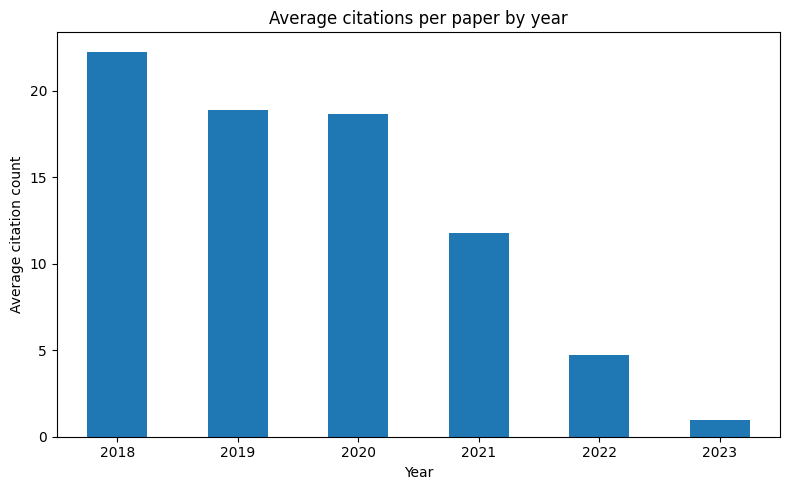

In [35]:
plt.figure(figsize=(8, 5))
df_cit_year["mean"].plot(kind="bar")
plt.title("Average citations per paper by year")
plt.xlabel("Year")
plt.ylabel("Average citation count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 12. Optional: abstract length vs. citations

As an exploratory question, we can check whether longer abstracts tend to receive more citations.
(This is not necessarily causal, but it’s an interesting descriptive plot.)


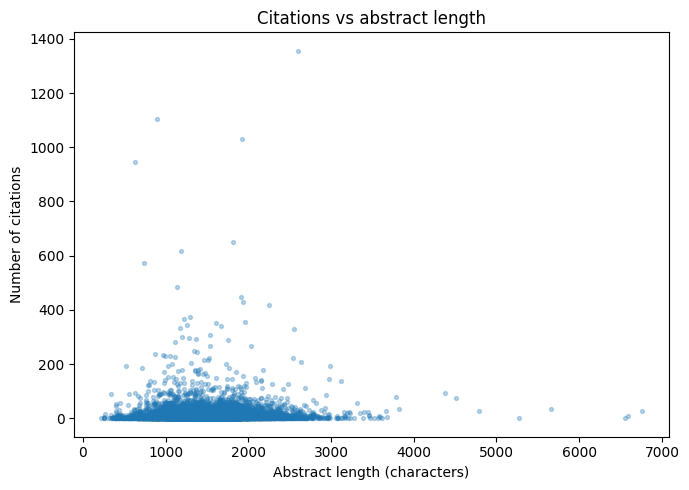

In [36]:
plt.figure(figsize=(7, 5))
plt.scatter(df_cit["abstract_length"], df_cit["citedby"], alpha=0.3, s=8)
plt.title("Citations vs abstract length")
plt.xlabel("Abstract length (characters)")
plt.ylabel("Number of citations")
plt.tight_layout()
plt.show()
